In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as warn
warn.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Importing and Saving the BTC-USD historical price data from Yahoo Finance

In [ ]:
btc_cc = yf.download("BTC-USD", start="2014-09-17", end="2025-03-31", auto_adjust=False)
btc_cc

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...,...
2025-03-26,86900.882812,86900.882812,88292.156250,85861.453125,87460.234375,26704046038
2025-03-27,87177.101562,87177.101562,87786.726562,85837.937500,86896.257812,24413471941


In [ ]:
# Cleaning the multi-level column names
btc_cc.reset_index(inplace=True)
btc_cc.columns = ['_'.join(filter(None, column_name)).strip() if isinstance(column_name, tuple) else column_name for column_name in btc_cc.columns]
btc_cc.columns = [column_name.replace('_BTC-USD', '') for column_name in btc_cc.columns]
btc_cc

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...,...,...
3843,2025-03-26,86900.882812,86900.882812,88292.156250,85861.453125,87460.234375,26704046038
3844,2025-03-27,87177.101562,87177.101562,87786.726562,85837.937500,86896.257812,24413471941
3845,2025-03-28,84353.148438,84353.148438,87489.859375,83557.640625,87185.234375,34198619509
3846,2025-03-29,82597.585938,82597.585938,84567.335938,81634.140625,84352.070312,16969396135


In [ ]:
btc_cc.to_csv('btc_usd.csv', index=False)

In [ ]:
btc_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3848 non-null   datetime64[ns]
 1   Adj Close  3848 non-null   float64       
 2   Close      3848 non-null   float64       
 3   High       3848 non-null   float64       
 4   Low        3848 non-null   float64       
 5   Open       3848 non-null   float64       
 6   Volume     3848 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 210.6 KB


Viewing the Start and End Dates in this imported BTC historical crypto trading data

In [ ]:
first_date = btc_cc['Date'].min()
last_date = btc_cc['Date'].max()

print("First trading date in this BTC historical data:", first_date.date())
print("Last trading date in this BTC historical data:", last_date.date())

First trading date in this BTC historical data: 2014-09-17
Last trading date in this BTC historical data: 2025-03-30


In [ ]:
print("Minimum BTC Closing Price:", btc_cc['Close'].min())
print("Maximum BTC Closing Price:", btc_cc['Close'].max())
print("Minimum BTC Opening Price:", btc_cc['Open'].min())
print("Maximum BTC Opening Price:", btc_cc['Open'].max())
print("Lowest recorded BTC high price:", btc_cc['High'].min())
print("Highest recorded BTC high price:", btc_cc['High'].max())
print("Lowest recorded BTC low price:", btc_cc['Low'].min())
print("Highest recorded BTC low price:", btc_cc['Low'].max())
print("Lowest recorded BTC trading volume:", btc_cc['Volume'].min())
print("Highest recorded BTC trading volume:", btc_cc['Volume'].max())

Minimum BTC Closing Price: 178.10299682617188
Maximum BTC Closing Price: 106146.265625
Minimum BTC Opening Price: 176.89700317382812
Maximum BTC Opening Price: 106147.296875
Lowest recorded BTC high price: 211.7310028076172
Highest recorded BTC high price: 109114.8828125
Lowest recorded BTC low price: 171.50999450683594
Highest recorded BTC low price: 105291.734375
Lowest recorded BTC trading volume: 5914570
Highest recorded BTC trading volume: 350967941479


# Data Analysis - Visualisation

**Seasonal Decomposition of Time Series**

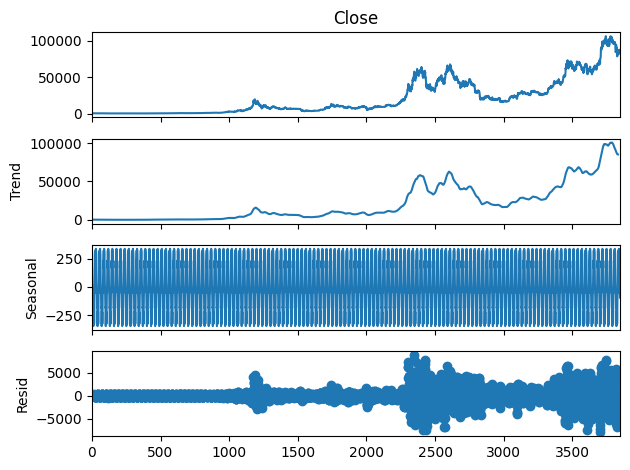

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decom = seasonal_decompose(btc_cc['Close'], model='additive', period=30)  # 30 days for monthly pattern
decom.plot()
plt.show()

This seasonal decomposition shows a strong upward trend in Bitcoin prices, a repeating seasonal pattern with consistent cycles, and residuals indicating increased volatility in recent years. It confirms non-stationarity and the presence of both trend and seasonality components.

**Rolling data - Moving Average - Average of the past 7 days**

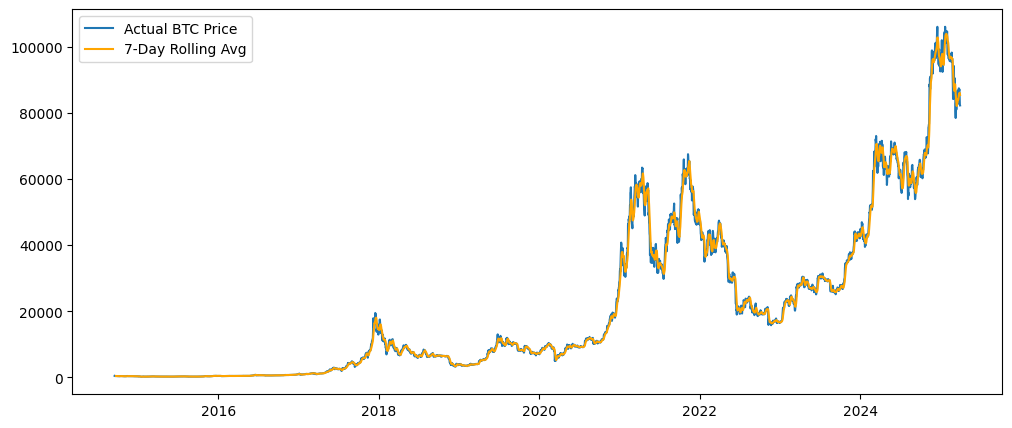

In [ ]:
btc_cc['Rolling_7'] = btc_cc['Close'].rolling(window=7).mean()

plt.figure(figsize=(12,5))
plt.plot(btc_cc['Date'], btc_cc['Close'], label='Actual BTC Price')
plt.plot(btc_cc['Date'], btc_cc['Rolling_7'], label='7-Day Rolling Avg', color='orange')
plt.legend()
plt.show()

The plot compares actual Bitcoin prices with a 7-day rolling average. The rolling average smooths out short-term fluctuations, revealing the underlying trend. Both lines closely align, indicating strong short-term momentum and highlighting periodic price spikes and corrections.

**Bitcoin End-of-Month Closing Price Trend**

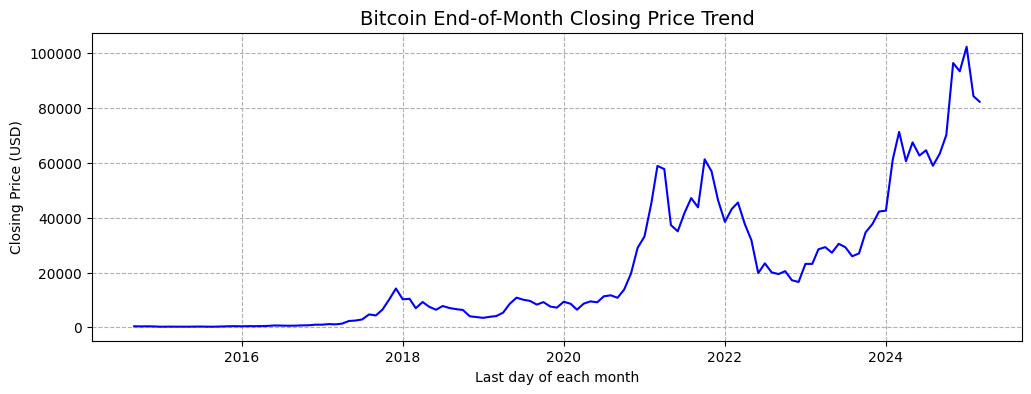

In [ ]:
# Creating a new column for Year-Month and keeping the last entry of each month
btc_cc['YearMonth'] = btc_cc['Date'].dt.to_period('M')
monthly_data = btc_cc.groupby('YearMonth').last().reset_index()

# Converting YearMonth back to datetime for plotting
monthly_data['Date'] = monthly_data['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(12, 4))
plt.plot(monthly_data['Date'], monthly_data['Close'], color='blue')
plt.title('Bitcoin End-of-Month Closing Price Trend', fontsize=14)
plt.xlabel('Last day of each month')
plt.ylabel('Closing Price (USD)')
plt.grid(True, linestyle='--')
plt.show()

The graph shows Bitcoins end-of-month closing price trend from 2014 to 2025. Prices remained low until 2017, followed by sharp fluctuations, peaking above $100,000 in 2024, indicating high volatility and rapid growth in recent years.

**Candle Stick Chart showing the monthly bitcoin price and the fluctuations**

In [ ]:
pip install plotly

In [ ]:
import plotly.graph_objects as go

# Grouping the data by year & month, and getting the last entry of each month
month_end_data = btc_cc.groupby([btc_cc['Date'].dt.to_period('M')]).agg({
    'Date': 'last', 'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'
    }).reset_index(drop=True)

# Creating the candlestick chart
Chart = go.Figure(data=[go.Candlestick(x=month_end_data['Date'],
                                       open=month_end_data['Open'],
                                       high=month_end_data['High'],
                                       low=month_end_data['Low'],
                                       close=month_end_data['Close'],
                                       increasing_line_color='green',
                                       decreasing_line_color='red')])

Chart.update_layout(title='Candlestick Chart - Monthly BTC Price',
                    xaxis_title='Last day of each month',
                    yaxis_title='BTC Price (USD)',
                    xaxis_rangeslider_visible=False)
Chart.show()

Th candlestick chart above shows monthly BTC price movements from 2014 to 2025, highlighting high volatility, sharp uptrends in 2017 and 2021, and a peak above $100,000 in 2024.

**Candle stick chart for the months Feb and March 2025**

In [ ]:
feb_mar = btc_cc[(btc_cc['Date'] >= '2025-02-01') & (btc_cc['Date'] <= '2025-03-31')]

# Creating the candlestick chart
Chart = go.Figure(data=[go.Candlestick(x=feb_mar['Date'],
                                       open=feb_mar['Open'],
                                       high=feb_mar['High'],
                                       low=feb_mar['Low'],
                                       close=feb_mar['Close'],
                                       increasing_line_color='green',
                                       decreasing_line_color='red')])

Chart.update_layout(title='Candlestick Chart - Daily BTC Price- Feb & March 2025',
                    xaxis_title='Date',
                    yaxis_title='BTC Price (USD)',
                    xaxis_rangeslider_visible=False)
Chart.show()

The candlestick above shows daily BTC price fluctuations from Feb to March 2025. The price fell from over $100k to around $85k, followed by minor recovery and sideways consolidation near month-end.

**Taking only the Date and Closing Price column for univariate time series analysis focused on BTC's closing price trend**

In [ ]:
btc_cc = btc_cc[['Date', 'Close']]
btc_cc.to_csv('btc_usd(date&Close).csv', index=False)
btc_cc

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3843,2025-03-26,86900.882812
3844,2025-03-27,87177.101562
3845,2025-03-28,84353.148438
3846,2025-03-29,82597.585938


# **Sliding window one-step ahead forecasting**

In [ ]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for LSTM: {X.shape}")

Input shape (X): (3838, 10)
Target shape (y): (3838,)
Example input: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511 423.20498657 411.57400513 404.42498779]
Expected output: 399.5199890136719
Reshaped input for LSTM: (3838, 10, 1)


**DAta Splitting into Training and Testing**

In [ ]:
split_date = np.datetime64('2025-01-01')
before_split_date = y_dates < split_date
from_2025_onward = y_dates >= split_date

# Splitting the dataset in to training and testing
X_train, X_test = X[before_split_date], X[from_2025_onward]
y_train, y_test = y[before_split_date], y[from_2025_onward]

print(f"\nTraining set of BTC closing prices:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Testing set of BTC closing prices:   X = {X_test.shape},   y = {y_test.shape}")


Training set of BTC closing prices:  X = (3749, 10, 1),  y = (3749,)
Testing set of BTC closing prices:   X = (89, 10, 1),   y = (89,)


**Scaling the Data using Robust Scaler**

In [ ]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

x_scaler = RobustScaler()
X_train_scaled = x_scaler.fit_transform(X_train_reshaped)
X_test_scaled = x_scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [ ]:
# Saving the full 3-month test set (after scaling) for using it in final code demonstration using saved model
np.savez("btc_test_3months_scaled.npz",
         X_test_scaled=X_test_scaled,
         y_test=y_test,  # original price ( this data is not scaled)
         y_scaler_center=y_scaler.center_,
         y_scaler_scale=y_scaler.scale_)

In [ ]:
X_train_scaled

array([[[-0.30396439],
        [-0.30508881],
        [-0.30610215],
        ...,
        [-0.30513103],
        [-0.30552862],
        [-0.30577299]],

       [[-0.30508881],
        [-0.30610215],
        [-0.30561989],
        ...,
        [-0.30552862],
        [-0.30577299],
        [-0.30594066]],

       [[-0.30610215],
        [-0.30561989],
        [-0.30596456],
        ...,
        [-0.30577299],
        [-0.30594066],
        [-0.30670429]],

       ...,

       [[ 3.01297192],
        [ 3.02202971],
        [ 3.0038714 ],
        ...,
        [ 2.95501615],
        [ 2.89927482],
        [ 2.93342641]],

       [[ 3.02202971],
        [ 3.0038714 ],
        [ 2.93140986],
        ...,
        [ 2.89927482],
        [ 2.93342641],
        [ 2.87758093]],

       [[ 3.0038714 ],
        [ 2.93140986],
        [ 2.91709744],
        ...,
        [ 2.93342641],
        [ 2.87758093],
        [ 2.84725975]]])

In [ ]:
y_test_scaled

array([2.89603143, 2.98004471, 3.02160852, 3.02599447, 3.02867563,
       3.15682214, 2.98126477, 2.91727266, 2.83011398, 2.90562407,
       2.90103167, 2.8983702 , 2.89932661, 2.96802978, 3.10323621,
       3.07777851, 3.23800342, 3.23616561, 3.12316134, 3.15473053,
       3.29535675, 3.21045543, 3.22091322, 3.25017558, 3.24660558,
       3.17740439, 3.15714911, 3.13143175, 3.21216288, 3.24730899,
       3.16795542, 3.10839235, 3.00735885, 3.13391577, 3.01358527,
       2.97080166, 2.97004743, 2.96786084, 2.96627285, 2.96687357,
       2.99879713, 2.94124293, 3.01406334, 2.97108845, 3.001229  ,
       3.00365982, 2.95580414, 2.94212672, 2.93416385, 2.97148831,
       3.02932184, 2.95411904, 2.96951828, 2.95917169, 2.79381778,
       2.70248705, 2.55302242, 2.56518634, 2.55390728, 2.61039837,
       2.8901945 , 2.61154793, 2.65093128, 2.76675877, 2.74422113,
       2.63460196, 2.61457601, 2.42545961, 2.35500217, 2.50245978,
       2.5317506 , 2.44131696, 2.54015297, 2.55288914, 2.49283

# **Unidirectional LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0272 - mae: 0.0854 - val_loss: 0.0082 - val_mae: 0.0576
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0023 - mae: 0.0247 - val_loss: 0.0141 - val_mae: 0.0735
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0022 - mae: 0.0245 - val_loss: 0.0055 - val_mae: 0.0495
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0020 - mae: 0.0235 - val_loss: 0.0068 - val_mae: 0.0510
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0018 - mae: 0.0216 - val_loss: 0.0137 - val_mae: 0.0835
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0015 - mae: 0.0200 - val_loss: 0.0055 - val_mae: 0.0466
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0012 - mae: 0.0177 - val_loss: 0.0068 - val_mae: 0.0525
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0012 - mae: 0.0175 - val_loss: 0.0110 - val_mae: 0.0723
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.00

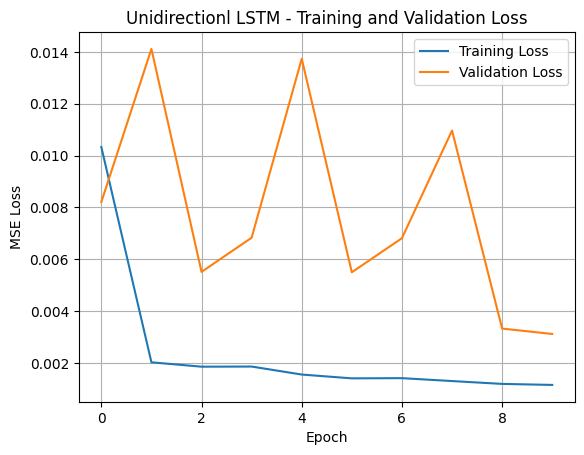

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

 Metrics: Unidirectional LSTM:
MAE  - 2237.4729
MSE  - 7956271.5100
RMSE - 2820.6864
R²   - 0.8523
MAPE - 2.39%



In [ ]:
# Building Uni-directional LSTM model for next-day price prediction
Uni_LSTM = Sequential()
Uni_LSTM.add(LSTM(300, activation='selu', input_shape=(window_size, 1)))
Uni_LSTM.add(Dense(1))
Uni_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Uni-LSTM model
history_uni_lstm = Uni_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_uni_lstm.history['loss'], label='Training Loss')
plt.plot(history_uni_lstm.history['val_loss'], label='Validation Loss')
plt.title('Unidirectionl LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
Uni_LSTM.save("btc_uni_lstm_model.keras")

#Predicting the closing price of BTC
y_pred = Uni_LSTM.predict(X_test_scaled).flatten()

# Inverse scaling
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Unidirectional LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Unidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 91841.5625

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 92575.625

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 94286.46875

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closing price      : 98236.22

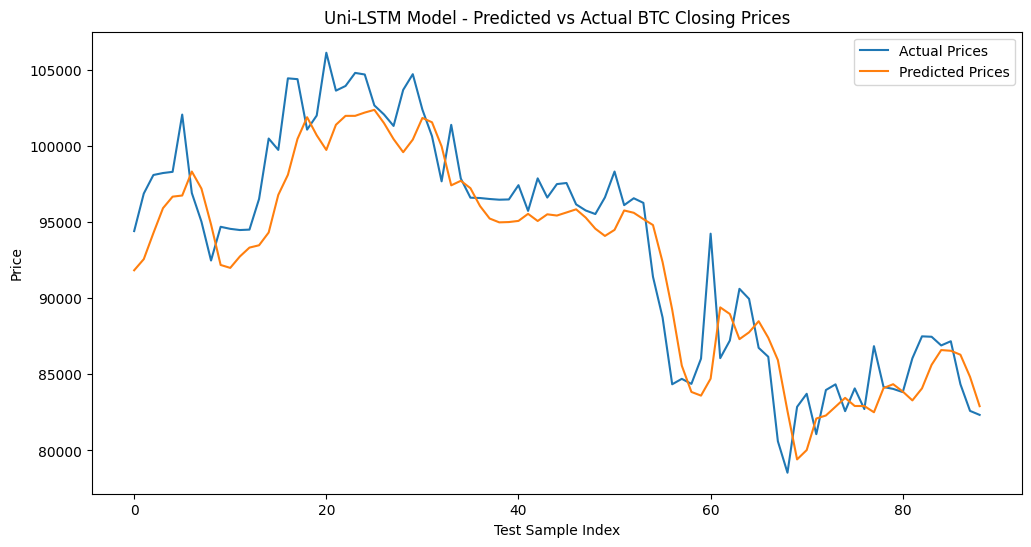

In [ ]:
print("\nSome test predictions of Unidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Uni-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Bidirectional LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0414 - mae: 0.0898 - val_loss: 0.0113 - val_mae: 0.0809
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0026 - mae: 0.0259 - val_loss: 0.0088 - val_mae: 0.0735
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.0031 - mae: 0.0299 - val_loss: 0.0114 - val_mae: 0.0694
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0018 - mae: 0.0233 - val_loss: 0.0118 - val_mae: 0.0678
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0017 - mae: 0.0223 - val_loss: 0.0056 - val_mae: 0.0532
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0016 - mae: 0.0210 - val_loss: 0.0073 - val_mae: 0.0533
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 0.0017 - mae: 0.0215 - val_loss: 0.0123 - val_mae: 0.0724
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0013 - mae: 0.0197 - val_loss: 0.0091 - val_mae: 0.0600
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - los

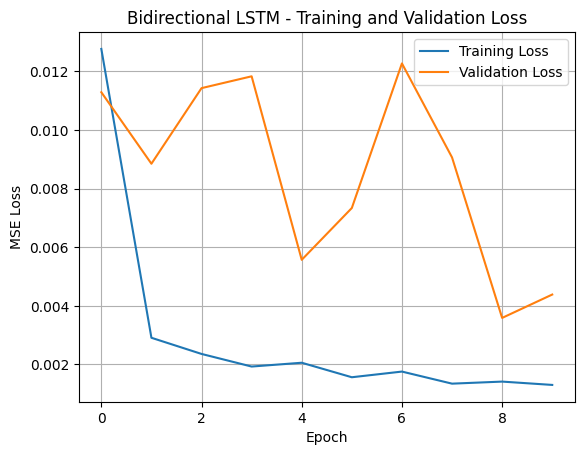

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step

 Metrics: Bidirectional LSTM:
MAE  - 2073.7580
MSE  - 7260599.5653
RMSE - 2694.5500
R²   - 0.8653
MAPE - 2.27%



In [ ]:
# Building Bi-directional LSTM model for next-day price prediction
Bi_LSTM = Sequential()
Bi_LSTM.add(Bidirectional(LSTM(300, activation='selu', input_shape=(window_size, 1))))
Bi_LSTM.add(Dense(1))
Bi_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Bi-LSTM model
history_bi_lstm = Bi_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_bi_lstm.history['loss'], label='Training Loss')
plt.plot(history_bi_lstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
Bi_LSTM.save("btc_bi_lstm_model.keras")

#Predicting the closing price of BTC
y_pred = Bi_LSTM.predict(X_test_scaled).flatten()

# Inverse scaling
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Bidirectional LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Bidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93559.890625

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 94372.296875

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 96121.8671875

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closing price      : 98

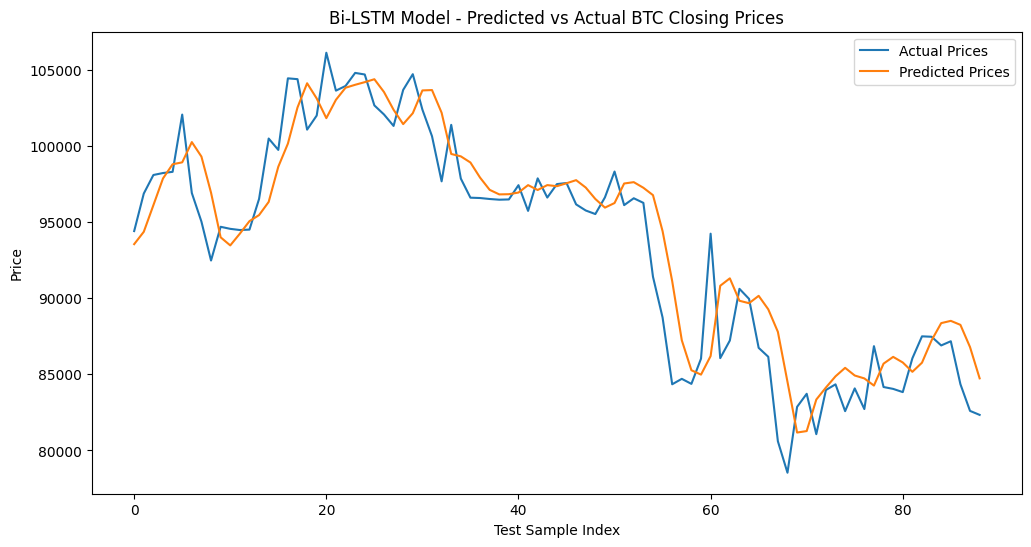

In [ ]:
print("\nSome test predictions of Bidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Bi-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Stacked LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - loss: 0.0251 - mae: 0.0915 - val_loss: 0.0143 - val_mae: 0.0964
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.0031 - mae: 0.0302 - val_loss: 0.0175 - val_mae: 0.0878
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0018 - mae: 0.0224 - val_loss: 0.0070 - val_mae: 0.0664
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.0019 - mae: 0.0232 - val_loss: 0.0043 - val_mae: 0.0432
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0015 - mae: 0.0205 - val_loss: 0.0193 - val_mae: 0.0966
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0016 - mae: 0.0216 - val_loss: 0.0032 - val_mae: 0.0379
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0011 - mae: 0.0177 - val_loss: 0.0029 - val_mae: 0.0371
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.0011 - mae: 0.0167 - val_loss: 0.0195 - val_mae: 0.1048
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 

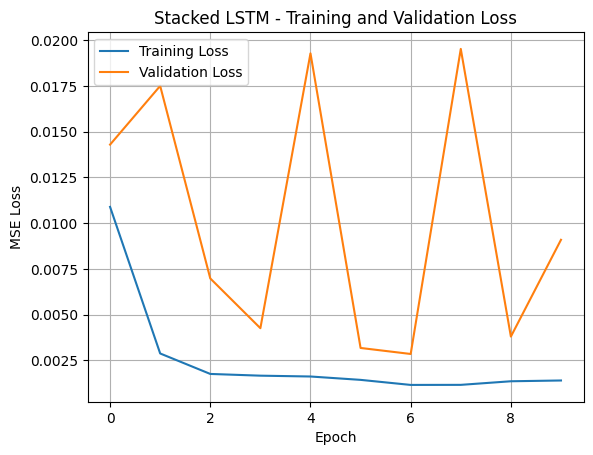

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step

 Metrics: Stacked LSTM:
MAE  - 1977.8121
MSE  - 6948578.9892
RMSE - 2636.0157
R²   - 0.8710
MAPE - 2.16%



In [ ]:
# Building Stacked LSTM model for next-day price prediction
stacked_LSTM = Sequential()
stacked_LSTM.add(LSTM(300, activation='selu', return_sequences=True, input_shape=(window_size, 1)))
stacked_LSTM.add(LSTM(150, activation='selu'))
stacked_LSTM.add(Dense(1))
stacked_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Stacked LSTM model
history_stacked_lstm = stacked_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_stacked_lstm.history['loss'], label='Training Loss')
plt.plot(history_stacked_lstm.history['val_loss'], label='Validation Loss')
plt.title('Stacked LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
stacked_LSTM.save("btc_stacked_lstm_model.keras")

#Predicting the closing price of BTC
y_pred = stacked_LSTM.predict(X_test_scaled).flatten()

# Inverse scaling
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Stacked LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Checking some test predictions - Stacked LSTM

Sample 1
Last 10 days input (closing price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93626.3125

Sample 2
Last 10 days input (closing price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 94289.71875

Sample 3
Last 10 days input (closing price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 95849.96875

Sample 4
Last 10 days input (closing price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closing price      : 98236.2265625
Predic

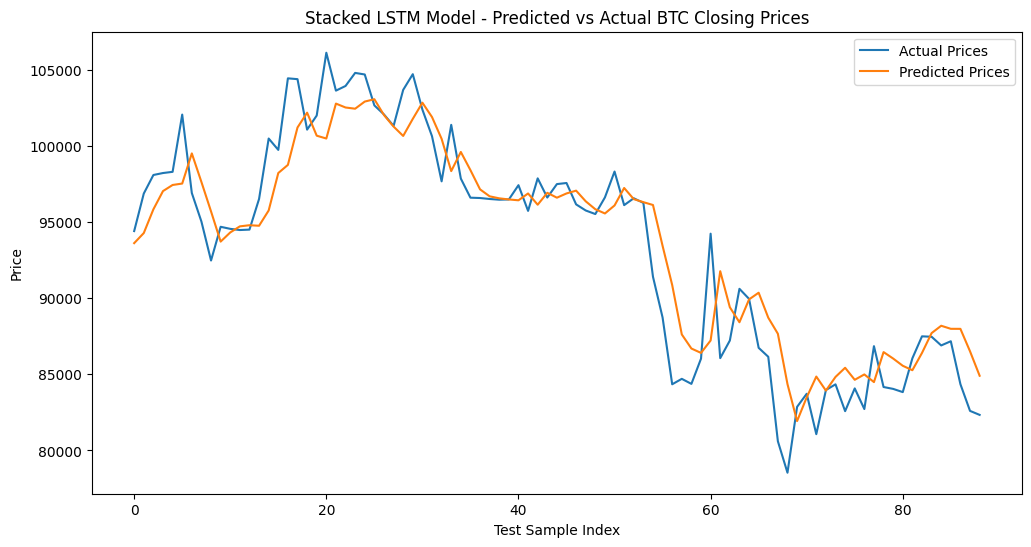

In [ ]:
print("\nChecking some test predictions - Stacked LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Stacked LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()